In [ ]:
from google.colab import drive
drive.mount('/content/drive')
words = '/content/drive/MyDrive/data/words_stream.txt'
counts = '/content/drive/MyDrive/data/counts.txt'
words_tiny = '/content/drive/MyDrive/data/words_stream_tiny.txt'
counts_tiny = '/content/drive/MyDrive/data/counts_tiny.txt'
hash_params_file = '/content/drive/MyDrive/data/hash_params.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
words_data = words
counts_data = counts

In [ ]:
#count lines
file = open(words_data, 'r')
stream_length = 0
for line in file:
    stream_length += 1
file.close()

#load words_freq_exact
word_freq_exact = {}
file = open(counts_data, 'r')
for line in file:
    chunk = line.strip().split('\t')
    word_id = int(chunk[0])
    count = int(chunk[1])
    word_freq_exact[word_id] = count
file.close()

#load hash parameters
hash_params = []
file = open(hash_params_file, 'r')
for line in file:
    parts = line.strip().split('\t')
    a = int(parts[0])
    b = int(parts[1])
    hash_params.append((a, b))
file.close()

NameError: name 'LogFormatter' is not defined

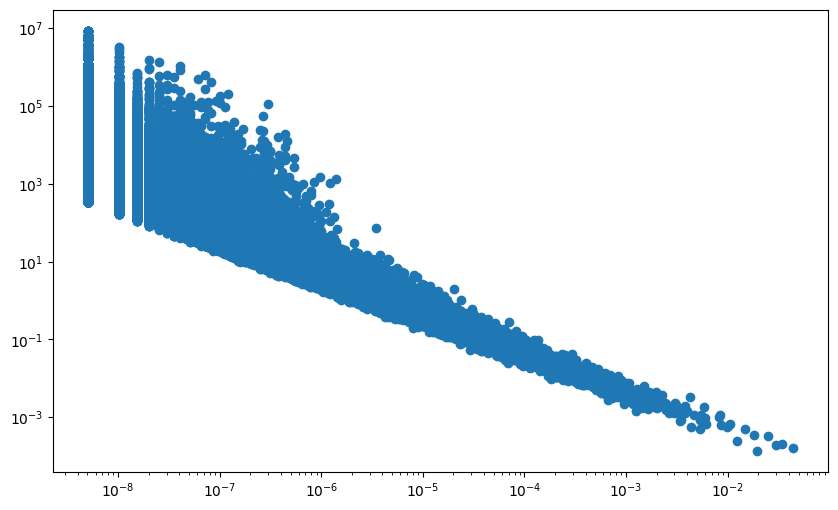

In [ ]:
def hash_fun(a, b, p, n_buckets, x):
    y = x % p
    hash_val = (a * y + b) % p
    return (hash_val % n_buckets) + 1

def approximate_frequencies(words_data, counts_data, hash_params, delta, epsilon):
    num_hash_functions = len(hash_params)
    n_buckets = int(np.ceil(np.exp(1) / epsilon))
    counters = np.zeros((num_hash_functions, n_buckets))

    file = open(words_data, 'r')
    for line in file:
        word_id = int(line.strip())
        j = 0
        for params in hash_params:
            a, b = params
            bucket = hash_fun(a, b, 123457, n_buckets, word_id)
            counters[j, bucket - 1] += 1
            j += 1
    file.close()

    word_freq_approx = {}
    file = open(counts_data, 'r')
    for line in file:
        parts = line.strip().split('\t')
        word_id = int(parts[0])
        count = int(parts[1])

        min_count = float('inf')
        j = 0
        for params in hash_params:
            a, b = params
            bucket = hash_fun(a, b, 123457, n_buckets, word_id) - 1
            count = counters[j, bucket]
            min_count = min(min_count, count)
            j += 1

        word_freq_approx[word_id] = min_count
    file.close()

    return word_freq_approx

#run algorithm
word_freq_approx = approximate_frequencies(words_data, counts_data, hash_params, delta = np.exp(-5), epsilon = np.exp(1) * 1e-4)

relative_errors = []
norm_freqs = []
for word_id, freq_approx in word_freq_approx.items():
    freq_exact = word_freq_exact[word_id]
    relative_error = (freq_approx - freq_exact) / freq_exact
    norm_freq = freq_exact / stream_length
    relative_errors.append(relative_error)
    norm_freqs.append(norm_freq)

plt.figure(figsize=(10, 6))
plt.scatter(norm_freqs, relative_errors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Word Frequency')
plt.ylabel('Relative Error')
plt.title('Relative Error vs Word Frequency')
plt.grid(True)
plt.show()

#test
print(f"\nword frequencies range: [{min(norm_freqs):.2e}, {max(norm_freqs):.2e}]")
print(f"errors range: [{min(relative_errors):.2e}, {max(relative_errors):.2e}]")